## Berlin rent prediction

In [1]:
## 1. Daten laden und Überblick

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Laden des Datensatzes
# Stellen Sie sicher, dass 'immo_data.csv' im Ordner 'data/' liegt
try:
    df = pd.read_csv('data/immo_data.csv')
    print("Datensatz erfolgreich geladen.")
except FileNotFoundError:
    print("Fehler: 'immo_data.csv' nicht gefunden. Stellen Sie sicher, dass die Datei im Ordner 'data/' liegt.")
    # Optional: Pfad anpassen oder Anweisungen zum Herunterladen geben

# Erster Überblick über die Daten
print("\n--- Daten-Info ---")
df.info()

print("\n--- Erste 5 Zeilen ---")
print(df.head())

print("\n--- Statistische Zusammenfassung ---")
print(df.describe())

## 2. Daten filtern: Nur Berlin

# Die Spalte 'regio2' oder 'regio3' könnte Berlin enthalten.
# Je nach Datensatz kann der Name der Spalte variieren.
# Es ist wichtig, die genaue Spalte zu identifizieren, die Städte/Regionen angibt.
# Oft ist 'regio2' für Bundesländer und 'regio3' für Städte/Landkreise.

# Beispiel basierend auf typischen Kaggle-Immobiliendaten:
# Angenommen, 'regio3' enthält Städtenamen und 'regio2' enthält Bundesländer
# Sie müssen dies anhand der tatsächlichen Spaltennamen in Ihrer 'immo_data.csv' überprüfen!

berlin_df = df[
    (df['regio2'] == 'Berlin') | # Manchmal ist Berlin direkt in regio2
    (df['regio3'] == 'Berlin')   # Manchmal ist Berlin in regio3
    ]

# Überprüfung, ob Daten für Berlin gefunden wurden
if berlin_df.empty:
    print("\nWarnung: Keine Daten für Berlin gefunden. Überprüfen Sie die Spaltennamen für die Region (z.B. 'regio2', 'regio3', 'city', 'state') und die Schreibweise von 'Berlin'.")
    # Versuchen Sie alternativ, die einzigartigen Werte der Regionalspalten anzuzeigen:
    # print(df['regio2'].unique())
    # print(df['regio3'].unique())
else:
    print(f"\n--- Daten für Berlin gefiltert ({len(berlin_df)} Einträge) ---")
    print(berlin_df.head())

## 3. Explorative Datenanalyse (EDA) - Berlin-spezifisch

# Hier würden Sie eine detailliertere Analyse der Berliner Daten durchführen.
# Beispiel: Verteilung der Mietpreise
plt.figure(figsize=(10, 6))
sns.histplot(berlin_df['price'], bins=50, kde=True)
plt.title('Verteilung der Kaltmieten in Berlin')
plt.xlabel('Kaltmiete (€)')
plt.ylabel('Anzahl der Angebote')
plt.show()

# Beispiel: Mietpreis pro Quadratmeter vs. Wohnfläche
plt.figure(figsize=(12, 7))
sns.scatterplot(x='livingSpace', y='price', data=berlin_df, alpha=0.6)
plt.title('Mietpreis vs. Wohnfläche in Berlin')
plt.xlabel('Wohnfläche (m²)')
plt.ylabel('Kaltmiete (€)')
plt.show()

# Umgang mit fehlenden Werten (Beispiel)
print("\n--- Fehlende Werte (Top 10) ---")
print(berlin_df.isnull().sum().sort_values(ascending=False).head(10))

## 4. Feature Engineering & Preprocessing (Vorbereitung für das Modell)

# Beispiel: Einfache Feature-Auswahl und Behandlung fehlender Werte
# Dies ist stark vereinfacht und muss an Ihren Datensatz angepasst werden!

# Auswahl relevanter Spalten (Beispielhafte Auswahl)
features = ['livingSpace', 'noRooms', 'yearConstructed', 'balcony', 'hasKitchen', 'garden', 'totalRent']
target = 'price' # Angenommen 'price' ist Ihre Kaltmiete

# Filtern der Berliner Daten auf relevante Features und den Target
berlin_model_df = berlin_df[features + [target]].copy()

# Umgang mit fehlenden Werten (Beispiel: Einfacher Imputations-Ansatz)
# Ersetzen Sie fehlende numerische Werte durch den Median
for col in ['livingSpace', 'noRooms', 'yearConstructed', 'totalRent']:
    if col in berlin_model_df.columns:
        berlin_model_df[col].fillna(berlin_model_df[col].median(), inplace=True)

# Ersetzen Sie fehlende Boolesche Werte (falls vorhanden) mit False oder 0
for col in ['balcony', 'hasKitchen', 'garden']:
    if col in berlin_model_df.columns:
        berlin_model_df[col].fillna(False, inplace=True) # Oder 0, je nach Datentyp

# Umwandlung von booleschen Werten in 0/1 (falls nicht schon geschehen)
for col in ['balcony', 'hasKitchen', 'garden']:
    if col in berlin_model_df.columns and berlin_model_df[col].dtype == 'bool':
        berlin_model_df[col] = berlin_model_df[col].astype(int)

# Entfernen von Zeilen mit NaN im Target (oder wenn nach Imputation noch NaN vorhanden sind)
berlin_model_df.dropna(subset=[target], inplace=True)

print(f"\n--- Daten nach Preprocessing ({len(berlin_model_df)} Einträge) ---")
print(berlin_model_df.info())

## 5. Modelltraining und Evaluierung (Skizze)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Aufteilen in Features (X) und Target (y)
X = berlin_model_df[features] # Target-Spalte sollte hier nicht enthalten sein
y = berlin_model_df[target]

# Sicherstellen, dass 'totalRent' nicht als Feature verwendet wird, wenn 'price' das Target ist
if 'totalRent' in X.columns and target == 'price':
    X = X.drop('totalRent', axis=1) # Beispielhafte Korrektur falls 'totalRent' ein Feature und 'price' Target ist

# Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Modell initialisieren und trainieren (Beispiel: Lineare Regression)
model = LinearRegression()
model.fit(X_train, y_train)

# Vorhersagen treffen
y_pred = model.predict(X_test)

# Modell evaluieren
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Modell-Evaluierung (Lineare Regression) ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Visualisierung der Vorhersagen vs. tatsächliche Werte
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Idealvorhersage-Linie
plt.title('Tatsächliche vs. Vorhergesagte Kaltmieten')
plt.xlabel('Tatsächliche Kaltmiete (€)')
plt.ylabel('Vorhergesagte Kaltmiete (€)')
plt.grid(True)
plt.show()

# Nächste Schritte:
# - Erweiterte Feature Engineering Techniken (z.B. PLZ in Kategorien umwandeln, Interaktionen)
# - Behandlung von Ausreißern
# - Einsatz komplexerer Modelle (Random Forest, Gradient Boosting, Neuronale Netze)
# - Hyperparameter-Optimierung
# - Kreuzvalidierung
# - Detailliertere Fehleranalyse

Datensatz erfolgreich geladen.

--- Daten-Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64 

KeyError: 'price'

<Figure size 1000x600 with 0 Axes>

In [ ]:
# 📦 1. Bibliotheken importieren
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from IPython.display import display

# 🔧 Plot-Stil setzen
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
plt.rcParams['figure.dpi'] = 120

# 📁 2. Daten laden
try:
    df = pd.read_csv('data/immo_data.csv')
    print("✅ Datensatz erfolgreich geladen.")
except FileNotFoundError:
    print("❌ Fehler: 'immo_data.csv' nicht gefunden. Stelle sicher, dass die Datei im Ordner 'data/' liegt.")

# 🔍 3. Überblick über die Daten
print("\n🧾 --- Datenübersicht ---")
df.info()

print("\n📋 Vorschau der ersten 5 Zeilen:")
display(df.head().style.set_caption("Erste 5 Zeilen").background_gradient(cmap='Blues'))

print("\n📊 Statistische Zusammenfassung:")
display(df.describe().style.background_gradient(cmap='YlGnBu'))

# 🗺️ 4. Daten für Berlin filtern
berlin_df = df[
    (df['regio2'] == 'Berlin') |
    (df['regio3'] == 'Berlin')
]

if berlin_df.empty:
    print("\n⚠️ Keine Daten für Berlin gefunden. Prüfe 'regio2', 'regio3' oder ähnliche Spalten.")
else:
    print(f"\n🏙️ Gefundene Einträge für Berlin: {len(berlin_df)}")
    display(berlin_df.head().style.set_caption("Beispielhafte Berliner Einträge").background_gradient(cmap='PuBu'))

# 📈 5. Explorative Datenanalyse (EDA)
plt.figure(figsize=(10, 6))
sns.histplot(berlin_df['price'], bins=50, kde=True, color="#4C72B0")
plt.title('Verteilung der Kaltmieten in Berlin', fontsize=16, fontweight='bold')
plt.xlabel('Kaltmiete (€)')
plt.ylabel('Anzahl der Angebote')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 7))
sns.scatterplot(
    x='livingSpace',
    y='price',
    data=berlin_df,
    alpha=0.5,
    color="#55A868",
    edgecolor='w'
)
plt.title('Kaltmiete vs. Wohnfläche in Berlin', fontsize=16, fontweight='bold')
plt.xlabel('Wohnfläche (m²)')
plt.ylabel('Kaltmiete (€)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\n🧩 Fehlende Werte (Top 10):")
print(berlin_df.isnull().sum().sort_values(ascending=False).head(10))

# 🛠️ 6. Feature Engineering & Preprocessing
features = ['livingSpace', 'noRooms', 'yearConstructed', 'balcony', 'hasKitchen', 'garden', 'totalRent']
target = 'price'

berlin_model_df = berlin_df[features + [target]].copy()

# Fehlende numerische Werte mit Median füllen
for col in ['livingSpace', 'noRooms', 'yearConstructed', 'totalRent']:
    berlin_model_df[col].fillna(berlin_model_df[col].median(), inplace=True)

# Fehlende boolesche Werte mit False füllen
for col in ['balcony', 'hasKitchen', 'garden']:
    berlin_model_df[col].fillna(False, inplace=True)

# Boolesche Werte in 0/1 umwandeln
for col in ['balcony', 'hasKitchen', 'garden']:
    if berlin_model_df[col].dtype == 'bool':
        berlin_model_df[col] = berlin_model_df[col].astype(int)

berlin_model_df.dropna(subset=[target], inplace=True)

print(f"\n📦 Daten nach Preprocessing: {len(berlin_model_df)} Einträge")
print(berlin_model_df.info())

# 💡 Korrelationsmatrix (optional)
plt.figure(figsize=(10, 8))
corr = berlin_model_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Korrelationsmatrix', fontsize=14)
plt.tight_layout()
plt.show()

# 🤖 7. Modelltraining (Lineare Regression)
X = berlin_model_df.drop(columns=[target, 'totalRent'], errors='ignore')
y = berlin_model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n📚 Trainingsdaten: {X_train.shape}, Testdaten: {X_test.shape}")

model = LinearRegression()
model.fit(X_train, y_train)

# 📊 8. Vorhersagen und Bewertung
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📈 --- Modell-Evaluierung ---")
print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R²: {r2:.2f}")

# 🔍 Visualisierung: Tatsächliche vs. Vorhergesagte Kaltmieten
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, alpha=0.4, edgecolors='w', color='#C44E52')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Tatsächliche vs. Vorhergesagte Kaltmieten', fontsize=16, fontweight='bold')
plt.xlabel('Tatsächliche Kaltmiete (€)')
plt.ylabel('Vorhergesagte Kaltmiete (€)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 🔍 Visualisierung: Fehlerverteilung
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=50, kde=True, color='#8172B3')
plt.title('Verteilung der Vorhersagefehler', fontsize=14, fontweight='bold')
plt.xlabel('Fehler (tatsächlich - vorhergesagt)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [1]:
# 📦 Aufgabe 1: Bibliotheken importieren & Plot-Stil setzen
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from IPython.display import display

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
plt.rcParams['figure.dpi'] = 120


In [2]:
# 📁 Aufgabe 2: Daten laden
try:
    df = pd.read_csv('data/immo_data.csv')
    print("✅ Datensatz erfolgreich geladen.")
except FileNotFoundError:
    print("❌ Fehler: 'immo_data.csv' nicht gefunden. Stelle sicher, dass die Datei im Ordner 'data/' liegt.")


✅ Datensatz erfolgreich geladen.


In [3]:
# 🔍 Aufgabe 3: Überblick über die Daten
print("\n🧾 --- Datenübersicht ---")
df.info()

print("\n📋 Vorschau der ersten 5 Zeilen:")
display(df.head().style.set_caption("Erste 5 Zeilen").background_gradient(cmap='Blues'))

print("\n📊 Statistische Zusammenfassung:")
display(df.describe().style.background_gradient(cmap='YlGnBu'))



🧾 --- Datenübersicht ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces      

/Users/adnansalem/Github/usw-assignment-05-llms-rag-adnansalem1/venv/lib/python3.13/site-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/adnansalem/Github/usw-assignment-05-llms-rag-adnansalem1/venv/lib/python3.13/site-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.000000,central_heating,ONE_YEAR_FREE,nan,False,False,6,4.620000,10.000000,840.000000,1965.000000,96107057,1.000000,oil,False,Nordrhein_Westfalen,True,2.000000,595.000000,244,86.000000,Dortmund,well_kept,normal,nan,Schüruferstraße,Schüruferstraße,False,4,ground_floor,44269,4.000000,181.400000,1.000000,3.000000,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnung befindet sich in einem gepflegten 8-Familienhaus. Aufgrund der Hanglage bietet sich ein unverbaubarer Blick ins Grüne.,"Die Wohnung ist mit Laminat ausgelegt. Das Badezimmer ist gefliest und verfügt über eine Wannendusche. Neue weiße Zimmertüren, ein Fliesenspiegel in der Küche und Fußleisten wurden kürzlich eingebaut. Zur Wohnung gehört ein 10 m großer Keller. Eine Garage kann optional mitgemietet werden.",nan,nan,nan,nan,nan,May19
1,Rheinland_Pfalz,134.000000,self_contained_central_heating,ONE_YEAR_FREE,nan,False,True,8,3.470000,10.000000,nan,1871.000000,111378734,2.000000,gas,False,Rheinland_Pfalz,False,1.000000,800.000000,nan,89.000000,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,nan,False,5,ground_floor,67459,3.000000,nan,nan,nan,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,"Alles neu macht der Mai – so kann es auch für Sie in 2019 sein! Genießen Sie das „reine“ Gefühl und die „Unberührtheit“, die diese Wohnung nach der Kernsanierung bietet. Sie verfügt über eine Wohnfläche von ca. 89 m² und einen äußerst gelungenen Grundriss. Aufgeteilt ist die Wohnung in einen großzügigen Wohn-Essbereich, eine Küche, ein Schlafzimmer, ein Kinder- oder Arbeitszimmer, ein Bad, ein Gäste-WC und einen Flur. Von der Küche aus haben Sie direkten Zugang zum Balkon, der zum gemütlichen Verweilen und Entspannen einlädt. Das Badezimmer ist ausgestattet mit Dusche, Toilette, Waschbecken und praktischem Handtuchheizkörper. Zudem gibt es hier jeweils einen Anschluss für die Waschmaschine und für den Trockner. Sämtliche Räume in der Wohnung sind lichtdurchflutet, freundlich und einladend, verstärkt durch die weißen, doppelt verglasten Alufenster und die weißen Wände. Die Böden sind mit pflegeleichtem Vinyl-Boden und Fliesen ausgelegt und somit auch für Allergiker geeignet. Beheizt wird die Wohnung mittels einer neuen, energieeffizienten Gas-Etagenheizung der Firma Vaillant. Im Keller steht allen Mietern ein gemeinschaftlicher Raum zur Verfügung, der für zusätzlichen Stauraum sorgt. Abgerundet wird dieses tolle Angebot durch 2 Stellplätze, auf dem Sie Ihre Fahrzeuge stets sicher und ohne Parkplatzsuche parken können. Wir werden uns bemühen Ihre Anfrage so rasch als möglich zu beantworten, bitte haben Sie jedoch Verständnis, wenn dies 1-2 Werktage in Anspruch nehmen kann!",nan,nan,nan,2019.000000,nan,nan,May19
2,Sachsen,255.000000,floor_heating,ONE_YEAR_FREE,10.000000,True,True,8,2.720000,2.400000,1300.000000,2019.000000,113147523,1.000000,nan,False,Sachsen,True,9.000000,965.000000,4,83.800000,Dresden,first_time_use,sophisticated,nan,Turnerweg,Turnerweg,True,6,apartment,1097,3.000000,nan,3.000000,4.000000,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,"Der Neubau entsteht im Herzen der Dresdner Neustadt. Das Baugrundstück befindet sich inmitten einer sehr gefragten Lage. Nicht nur die zentrale Lage und die schnelle öffentliche Verkehrsanbindung durch den zu Fuß erreichbaren Bahnhof, wie auch Nahverkehrsanbindung, sondern auch die Architektur werden diesen Neubaukomplex 


📊 Statistische Zusammenfassung:


,serviceCharge,telekomHybridUploadSpeed,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,yearConstructedRange,baseRent,livingSpace,baseRentRange,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,livingSpaceRange,heatingCosts,lastRefurbish,electricityBasePrice,electricityKwhPrice
count,261941.000000,45020.000000,268850.000000,267018.000000,235492.000000,228333.000000,211805.000000,268850.000000,93052.000000,211805.000000,268850.000000,268850.000000,268850.000000,268850.000000,268850.000000,162344.000000,217541.000000,171118.000000,268850.000000,268850.000000,85518.000000,80711.000000,46846.000000,46846.000000
mean,151.206113,10.000000,9.791958,3.389001,28.804928,901.331522,1966.400590,106969670.362946,1.327634,3.714544,694.129432,74.355548,3.765256,37283.022235,2.641261,114.749533,2.122405,3.572319,2.571542,3.070790,76.990866,2013.904536,89.113612,0.199769
std,308.295790,0.000000,6.408399,1.964874,16.337151,33238.333822,46.992207,12500933.414895,8.361403,2.738134,19536.017580,254.759208,2.214357,27798.037296,2.633440,61.653663,3.634934,6.375496,0.937594,1.407127,147.716278,10.963125,5.395805,0.009667
min,0.000000,10.000000,0.000000,-12.330000,1.000000,0.000000,1000.000000,28871743.000000,0.000000,1.000000,0.000000,0.000000,1.000000,852.000000,1.000000,0.100000,-1.000000,0.000000,1.000000,1.000000,0.000000,1015.000000,71.430000,0.170500
25%,95.000000,10.000000,6.000000,2.000000,10.000000,469.800000,1950.000000,106691034.000000,1.000000,1.000000,338.000000,54.000000,2.000000,9128.000000,2.000000,79.000000,1.000000,2.000000,2.000000,2.000000,54.000000,2012.000000,90.760000,0.191500
50%,135.000000,10.000000,9.000000,3.390000,40.000000,650.000000,1973.000000,111158376.000000,1.000000,3.000000,490.000000,67.320000,3.000000,38667.000000,3.000000,107.000000,2.000000,3.000000,3.000000,3.000000,70.000000,2017.000000,90.760000,0.198500
75%,190.000000,10.000000,13.000000,4.570000,40.000000,985.000000,1996.000000,113768759.500000,1.000000,5.000000,799.000000,87.000000,5.000000,57072.000000,3.000000,140.300000,3.000000,4.000000,3.000000,4.000000,90.000000,2019.000000,90.760000,0.205500
max,146118.000000,10.000000,121.000000,14.920000,100.000000,15751535.000000,2090.000000,115711743.000000,2241.000000,9.000000,9999999.000000,111111.000000,9.000000,99998.000000,999.990000,1996.000000,999.000000,999.000000,5.000000,7.000000,12613.000000,2919.000000,90.760000,0.227600


In [4]:
# 🗺️ Aufgabe 4: Filterung auf Berlin
berlin_df = df[(df['regio2'] == 'Berlin') | (df['regio3'] == 'Berlin')]

if berlin_df.empty:
    print("\n⚠️ Keine Daten für Berlin gefunden.")
else:
    print(f"\n🏙️ Gefundene Einträge für Berlin: {len(berlin_df)}")
    display(berlin_df.head().style.set_caption("Beispielhafte Berliner Einträge").background_gradient(cmap='PuBu'))



🏙️ Gefundene Einträge für Berlin: 10406


/Users/adnansalem/Github/usw-assignment-05-llms-rag-adnansalem1/venv/lib/python3.13/site-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/adnansalem/Github/usw-assignment-05-llms-rag-adnansalem1/venv/lib/python3.13/site-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
45,Berlin,320.000000,central_heating,nan,nan,False,True,10,4.990000,nan,1140.000000,nan,115671495,1.000000,nan,True,Berlin,False,nan,820.000000,63,77.000000,Berlin,nan,nan,negotiable,Metropolitan Park,Metropolitan_Park,True,6,ground_floor,13591,3.000000,nan,0.000000,3.000000,3,False,3,Berlin,Staaken_Spandau,"Diese attraktive EG-Wohnung kann ab sofort bezogen werden. Bei diesem Angebot handelt es sich um eine großzügige und komfortable 3-Zimmer Wohnung im Erdgeschoss eines komplett sanierten und modernisierten Gebäudes eines ehemaligen und unter Denkmalschutz stehenden Gebäudes. Die ca. 77m2 gro-ße Wohnung ist ausgesprochen großzügig, hell und gut geschnitten und verfügt über eine geschmackvolle luxuriöse Ausstattung. Der Fußboden in der gesamten Wohnung ist mit Eichen-Parkett versehen. Über einen Eingangsbereich mit Garderobennische betritt man die Wohnung. Von hier aus gelangt man in das elegante Wohnzimmer (ca 28m2) sowie auf die Ter-rasse (ca 13m2). Der Küchenbereich der Wohnung ist mit einer modernen und voll-ausgestatteten Einbauküche versehen. Die monatlichen Kosten hierfür betragen 50,00€. Das schöne Schlafzimmer (ca 12m2) ist funktional und großzügig geschnitten und verfügt zusätzlich über einen Ankleidebereich. Ein weiteres Zimmer (Arbeits- oder Gästezimmer) befindet sich neben dem Wohnzimmer und ist durch eine Schiebetür getrennt. Die Wohnung ist mit einem großen, modernen Badezimmer mit ebenerdiger Dusche ausgestattet. Sowohl Fliessn als auch Objekte und Armaturen sind von hochwertiger Qualität. Der Anschluss für eine Waschmaschine ist im Badezimmer vorhanden. In allen Räumen liegt sowohl Telefon- als auch digitaler Kabelanschluss. Die Kosten für Telefon, Internet und Strom sind nicht in den Nebenkosten enthalten. Die Wohnung ist ab sofort bezugsfertig. Die nachstehenden Konditionen sind freibleibend. Nettokaltmiete: € 820,00 Zzgl. Nebenkosten: € 230,00 Einbauküche: € 50,00 Stellplatz Nr. 34: €. 40,00 Gesamtmiete: € 1.140,00 Kaution:",nan,nan,nan,nan,nan,nan,Feb20
61,Berlin,79.000000,central_heating,ONE_YEAR_FREE,nan,False,False,17,7.350000,40.000000,955.000000,1918.000000,113359456,nan,gas,False,Berlin,False,1.000000,808.000000,11,62.630000,Berlin,refurbished,nan,negotiable,Börnestraße,Börnestraße,False,6,ground_floor,13086,2.000000,100.400000,0.000000,3.000000,2,False,3,Berlin,Weißensee_Weißensee,"Suchen Sie eine 2-Zimmerwohnung in Weißensee? Willkommen in der Börnestraße 11! Die Wohnung befindet sich im Vorderhaus im Erdgeschoss eines Altbaus und verfügt über zwei separate Zimmer (WG-geeignet), ein modernes Wannenbad mit Fenster und eine Küche mit Spüle und Herd (auf Wunsch). Es wird ein unbefristeter Mietvertrag mit einer Mindestmietlaufzeit von 15 Monaten angeboten (inkl. Kündigungsfrist). Die Staffelmiete beträgt 3,5 % jährlich, bezieht sich auf die Nettokaltmiete und ist auf 10 Jahre begrenzt.",Zusammengefasst bietet die Wohnung: + Vollständig Saniert! + 2 Zimmer (WG-geeignet) + Bad mit Wanne und Fenster + Küche mit Herd und Spüle + Zentralheizung,68.000000,nan,nan,nan,nan,Oct19
77,Berlin,150.000000,floor_heating,ONE_YEAR_FREE,nan,True,True,15,6.600000,40.000000,1300.000000,2019.000000,113704695,1.000000,district_heating,True,Berlin,True,9.000000,1150.000000,27,46.400000,Berlin,first_time_use,luxury,no,Stallschreiberstraße,Stallschreiberstraße,True,7,apartment,10179,2.000000,nan,3.000000,5.000000,2,False,2,Berlin,Mitte_Mitte,"Dieses lu

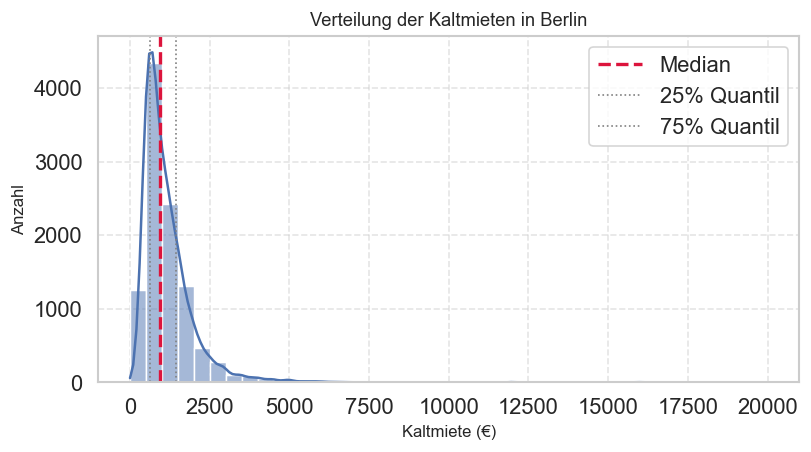

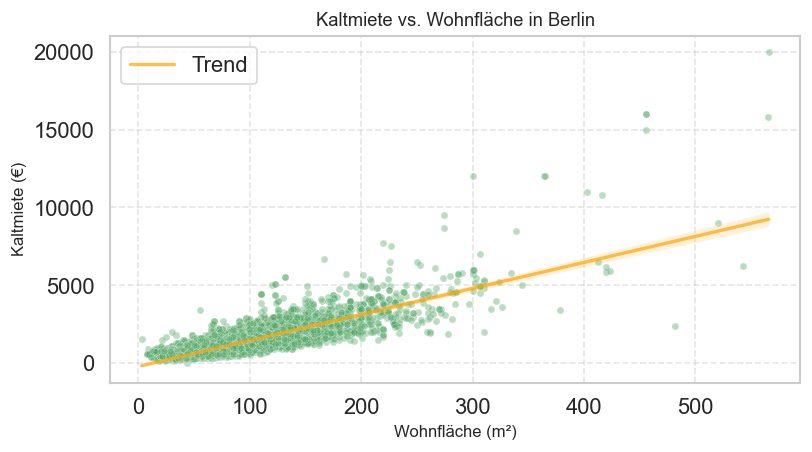

/var/folders/1g/h_r8d9gn1c38yw6dq6lsp_pc0000gn/T/ipykernel_23946/3689151239.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.values * 100, y=missing.index, palette="Blues_r")


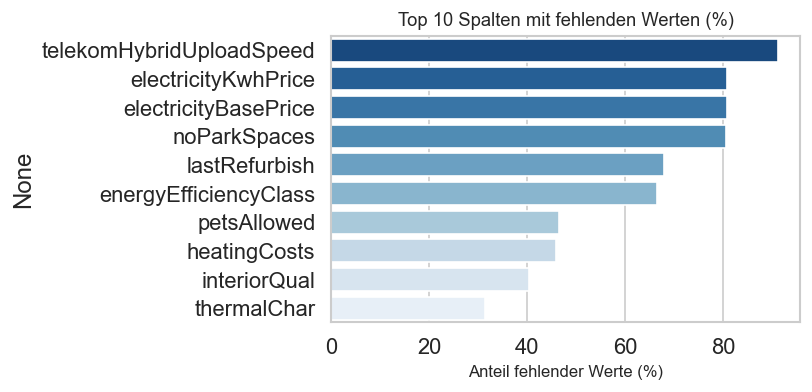


🧩 Fehlende Werte (Top 10):
telekomHybridUploadSpeed    9488
electricityKwhPrice         8411
electricityBasePrice        8411
noParkSpaces                8393
lastRefurbish               7070
energyEfficiencyClass       6917
petsAllowed                 4838
heatingCosts                4769
interiorQual                4208
thermalChar                 3275
dtype: int64


In [5]:
# 📈 Aufgabe 5: Explorative Datenanalyse (EDA)
#Kaltmieten-Verteilung – kompakter & mit Quantilen
plt.figure(figsize=(7, 4))
sns.histplot(berlin_df['baseRent'], bins=40, kde=True, color="#4C72B0")
plt.title('Verteilung der Kaltmieten in Berlin', fontsize=11)
plt.xlabel('Kaltmiete (€)', fontsize=10)
plt.ylabel('Anzahl', fontsize=10)
plt.axvline(berlin_df['baseRent'].median(), color='crimson', ls='--', lw=2, label='Median')
plt.axvline(berlin_df['baseRent'].quantile(0.25), color='grey', ls=':', lw=1, label='25% Quantil')
plt.axvline(berlin_df['baseRent'].quantile(0.75), color='grey', ls=':', lw=1, label='75% Quantil')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Scatterplot Kaltmiete vs Wohnfläche – komprimiert & mit Trendlinie

plt.figure(figsize=(7, 4))
sns.scatterplot(x='livingSpace', y='baseRent', data=berlin_df, alpha=0.4, color="#55A868", edgecolor='w', s=18)
sns.regplot(x='livingSpace', y='baseRent', data=berlin_df, scatter=False, color='orange', line_kws={'lw':2, 'alpha':0.7}, label='Trend')
plt.title('Kaltmiete vs. Wohnfläche in Berlin', fontsize=11)
plt.xlabel('Wohnfläche (m²)', fontsize=10)
plt.ylabel('Kaltmiete (€)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

#Fehlende Werte – Barplot 

missing = berlin_df.isnull().mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(7, 3.5))
sns.barplot(x=missing.values * 100, y=missing.index, palette="Blues_r")
plt.title("Top 10 Spalten mit fehlenden Werten (%)", fontsize=11)
plt.xlabel("Anteil fehlender Werte (%)", fontsize=10)
plt.tight_layout()
plt.show()

print("\n🧩 Fehlende Werte (Top 10):")
print(berlin_df.isnull().sum().sort_values(ascending=False).head(10))


In [6]:
# 🛠️ Aufgabe 6: Feature Engineering & Preprocessing (FutureWarning-frei!)
features = ['livingSpace', 'noRooms', 'yearConstructed', 'balcony', 'hasKitchen', 'garden', 'totalRent']
target = 'baseRent'

berlin_model_df = berlin_df[features + [target]].copy()

# Fehlende numerische Werte mit Median füllen (warnungsfrei)
for col in ['livingSpace', 'noRooms', 'yearConstructed', 'totalRent']:
    berlin_model_df[col] = berlin_model_df[col].fillna(berlin_model_df[col].median())

# Fehlende boolesche Werte mit False füllen und als int kodieren (warnungsfrei)
for col in ['balcony', 'hasKitchen', 'garden']:
    berlin_model_df[col] = berlin_model_df[col].fillna(False)
    berlin_model_df[col] = berlin_model_df[col].astype(int)

# Zielvariable darf nicht fehlen
berlin_model_df = berlin_model_df.dropna(subset=[target])

print(f"\n📦 Daten nach Preprocessing: {len(berlin_model_df)} Einträge")
print(berlin_model_df.info())



📦 Daten nach Preprocessing: 10406 Einträge
<class 'pandas.core.frame.DataFrame'>
Index: 10406 entries, 45 to 268829
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   livingSpace      10406 non-null  float64
 1   noRooms          10406 non-null  float64
 2   yearConstructed  10406 non-null  float64
 3   balcony          10406 non-null  int64  
 4   hasKitchen       10406 non-null  int64  
 5   garden           10406 non-null  int64  
 6   totalRent        10406 non-null  float64
 7   baseRent         10406 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 731.7 KB
None


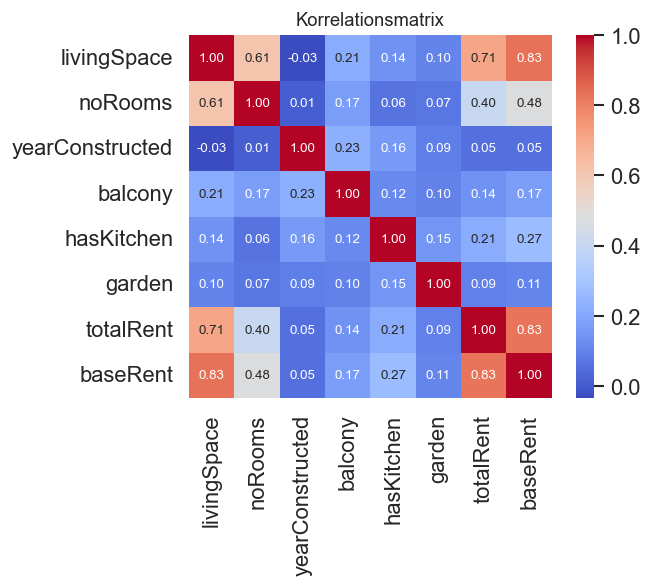

In [7]:
# 💡 Aufgabe 7: Kompakte Korrelationsmatrix
plt.figure(figsize=(6, 5))  # kleineres Format
corr = berlin_model_df.corr(numeric_only=True)
sns.heatmap(
    corr, annot=True, cmap='coolwarm', fmt='.2f', square=True, 
    annot_kws={"size": 8}  # kleinere Schrift für Werte
)
plt.title('Korrelationsmatrix', fontsize=11)
plt.tight_layout()
plt.show()


In [8]:
# 🤖 Aufgabe 8: Modelltraining (Lineare Regression)
X = berlin_model_df.drop(columns=[target, 'totalRent'], errors='ignore')
y = berlin_model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n📚 Trainingsdaten: {X_train.shape}, Testdaten: {X_test.shape}")

model = LinearRegression()
model.fit(X_train, y_train)



📚 Trainingsdaten: (8324, 6), Testdaten: (2082, 6)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [9]:
# 📊 Aufgabe 9: Vorhersagen und Bewertung
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📈 --- Modell-Evaluierung ---")
print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R²: {r2:.2f}")



📈 --- Modell-Evaluierung ---
✅ MAE: 297.94
✅ RMSE: 507.00
✅ R²: 0.70


NameError: name 'errors' is not defined

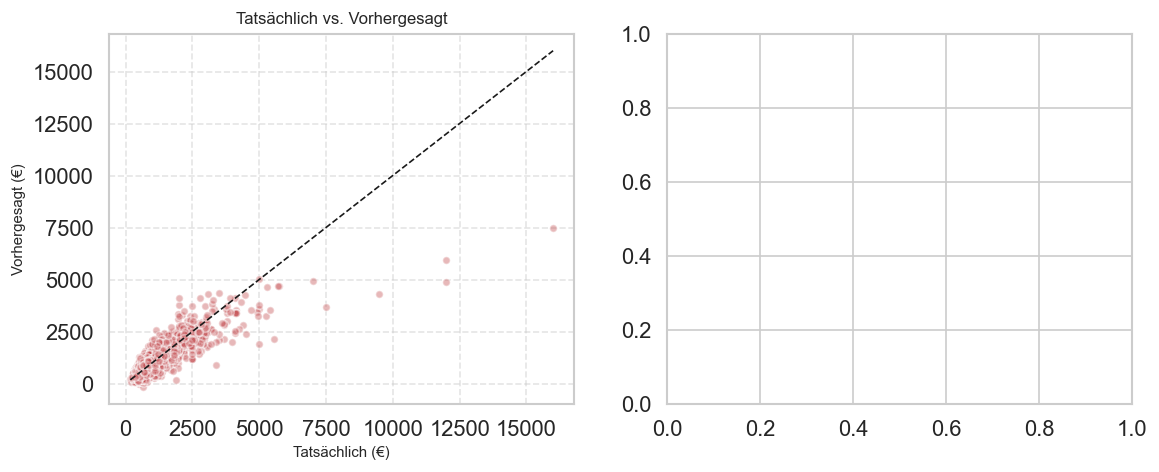

In [10]:
# 🔍 Aufgabe 10: Visualisierungen
# Tatsächliche vs. Vorhergesagte Werte
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Plot 1: Scatter
axes[0].scatter(y_test, y_pred, alpha=0.4, edgecolors='w', color='#C44E52', s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
axes[0].set_title('Tatsächlich vs. Vorhergesagt', fontsize=10)
axes[0].set_xlabel('Tatsächlich (€)', fontsize=9)
axes[0].set_ylabel('Vorhergesagt (€)', fontsize=9)
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plot 2: Fehlerverteilung
sns.histplot(errors, bins=40, kde=True, color='#8172B3', ax=axes[1])
axes[1].set_title('Fehlerverteilung', fontsize=10)
axes[1].set_xlabel('Fehler (€)', fontsize=9)
axes[1].set_ylabel('Anzahl', fontsize=9)
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

